# Tutorial: Introduction to GPU-Accelerated Image Processing with CuPy and cuCIM

In this brief tutorial, we'll explore how to use CuPy and cuCIM for high-performance image processing on NVIDIA GPUs. This session is designed to give you a quick start into GPU-accelerated image operations.

## Prerequisites
Ensure you have CuPy and cuCIM installed in your environment. If not, you can install them for your specific CUDA version:

Install for CUDA 12:
```bash
pip install cucim-cu12
````

Alternatively install for CUDA 11:

```bash
pip install cucim-cu11
```


In [1]:
from skimage import io
import cucim.skimage
import cupy as cp
import matplotlib.pyplot as plt

## Load and Display an Image

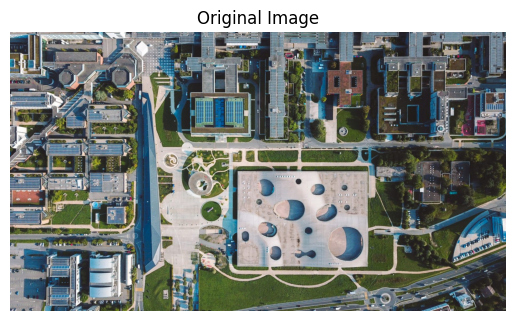

In [2]:
image = io.imread('EPFL_aereal.jpeg')
# Display the image
plt.imshow(image)
plt.title('Original Image')
plt.axis('off') 
plt.show()

## Convert Image to Grayscale using CuPy

Here we utilize CuPy to convert the image to grayscale, demonstrating the GPU's capability to handle pixel-wise operations.

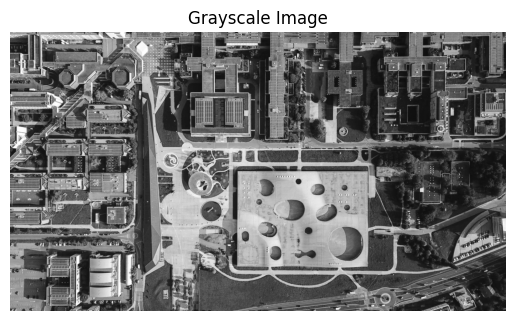

Conversion Time on GPU: 0.69427 ms


In [7]:
def rgb2gray_cupy(result, image):    
    result[...] = (0.21 * image[..., 0] + 0.72 * image[..., 1] + 0.07 * image[..., 2])
    return result


# Send image to device
image_device = cp.asarray(image)
gray_image_device = cp.zeros_like(image_device[...,0])

# Convert and time the operation
start_gpu = cp.cuda.Event(); end_gpu = cp.cuda.Event()
start_gpu.record()
gray_image_device = rgb2gray_cupy(gray_image_device, image_device)
end_gpu.record()
end_gpu.synchronize()
gpu_time = cp.cuda.get_elapsed_time(start_gpu, end_gpu)

gray_image = gray_image_device.get()

# Display the grayscale image
plt.imshow(gray_image, cmap='gray')  # .get() transfers data back to host
plt.title('Grayscale Image')
plt.axis('off')
plt.show()

print(f"Conversion Time on GPU: {gpu_time:.5f} ms")

## Advanced Image Processing: Edge Detection using cuCIM

*(Example edited from [cuCIM's documentation](https://github.com/rapidsai/cucim/blob/160c5e64dbd65e7bc96b272e8c18f4b97363afb4/notebooks/gabor_example.ipynb))*

Next, let's apply an edge detection filter using cuCIM, which utilizes optimized GPU routines.


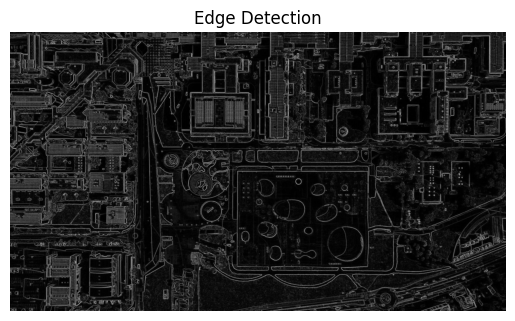

In [8]:
from cucim.skimage import filters

# Apply edge detection
edges = filters.sobel(gray_image_device)

# Display the edges
plt.imshow(edges.get(), cmap='gray')
plt.title('Edge Detection')
plt.axis('off')
plt.show()

Conclusion

This tutorial introduced you to basic and slightly advanced GPU-accelerated image processing techniques using CuPy and cuCIM. By offloading computationally intensive tasks to the GPU, significant performance improvements can be achieved, as demonstrated in the grayscale conversion and edge detection examples.

Rotated images matched against references using Gabor filter banks:
original: brick, rotated: 30deg, match result: brick
original: brick, rotated: 70deg, match result: brick
original: grass, rotated: 145deg, match result: brick
Duration cpu = 6.299292802810669 s


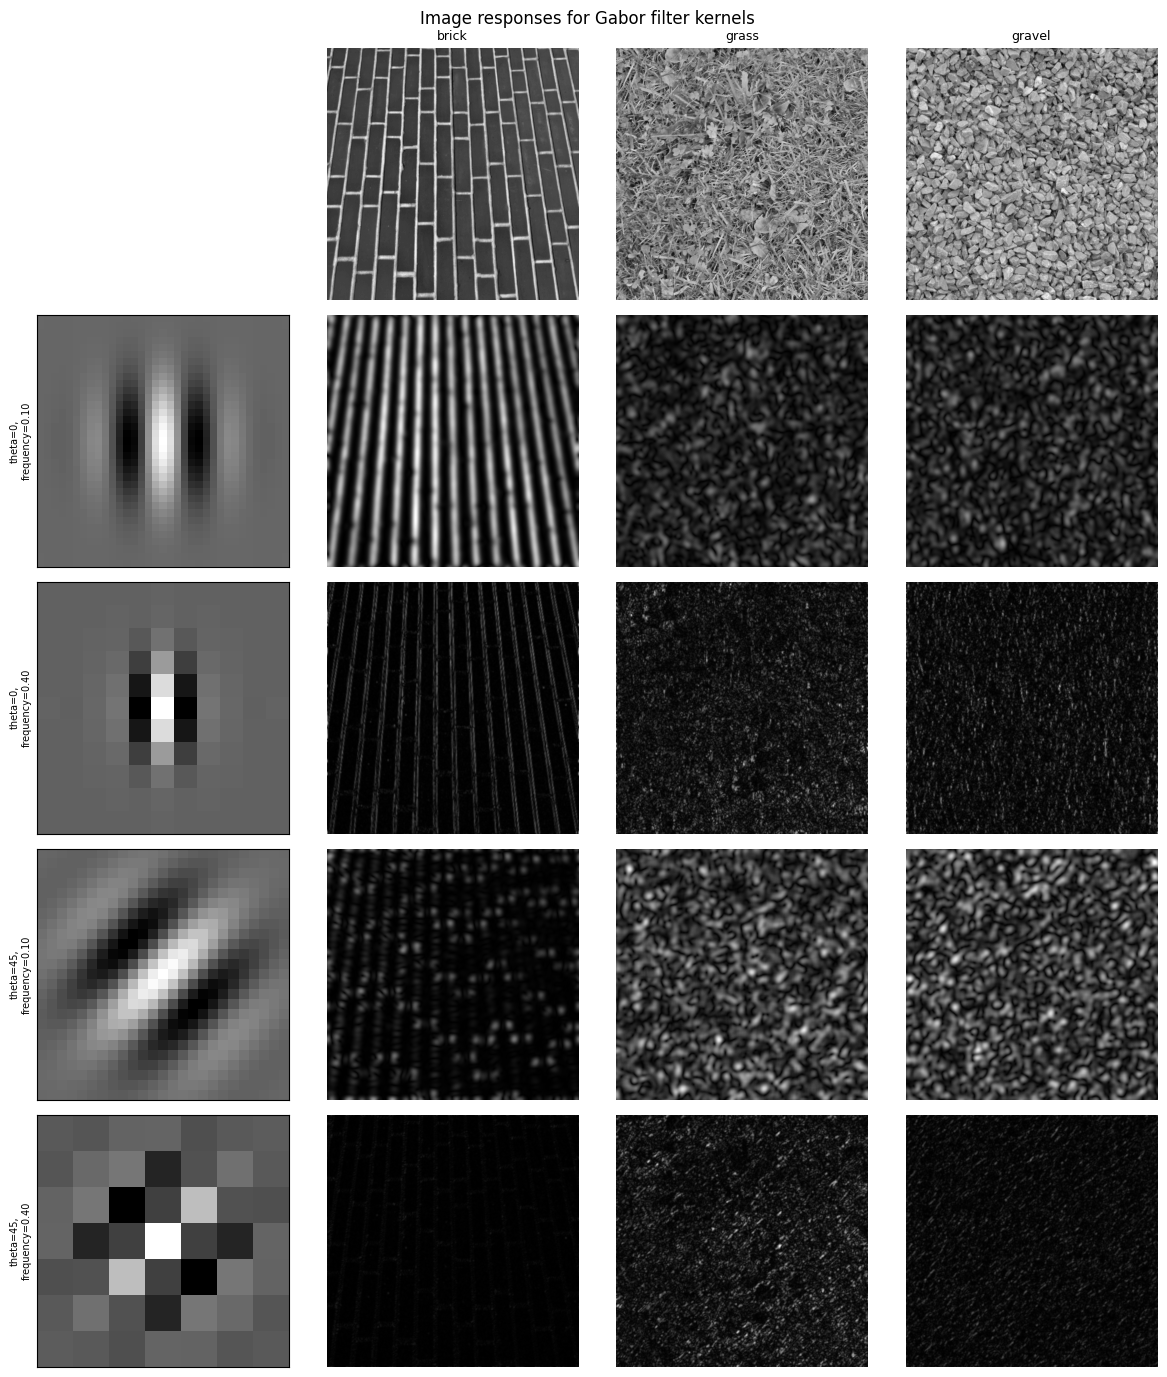

Rotated images matched against references using Gabor filter banks:
original: brick, rotated: 30deg, match result: brick
original: brick, rotated: 70deg, match result: brick
original: grass, rotated: 145deg, match result: brick
Duration gpu = 0.13782525062561035 s


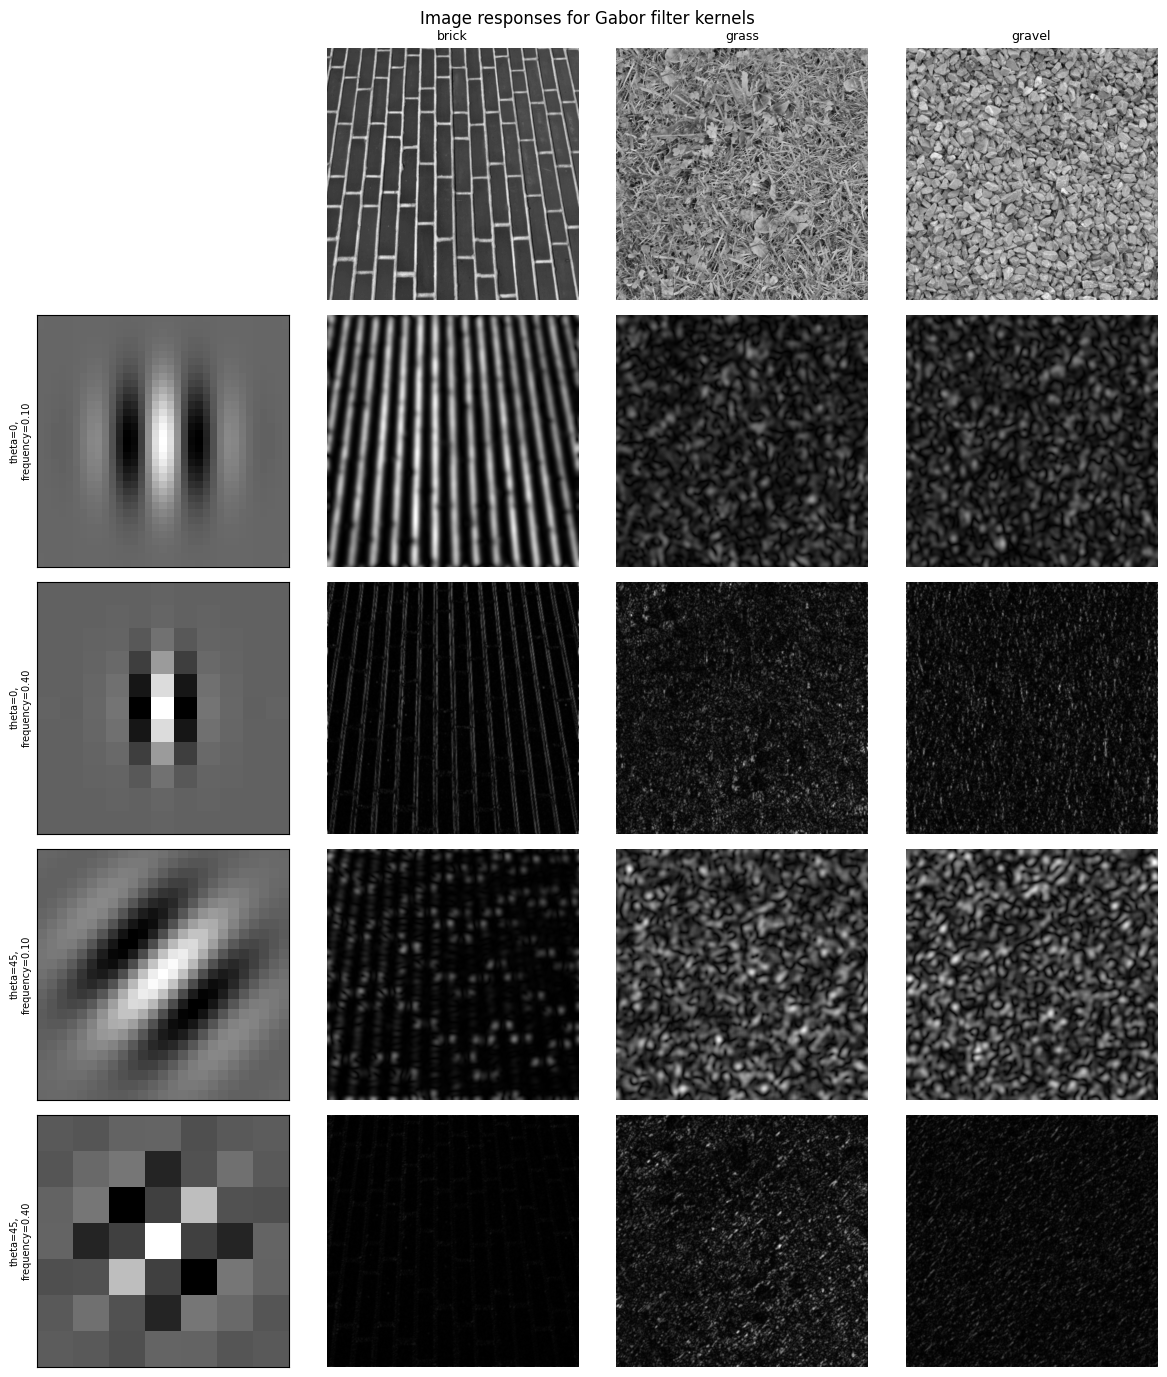

GPU Acceleration = 45.7049


In [6]:
import time

import cupy as cp
import matplotlib.pyplot as plt
import numpy as np
from skimage import data

durations = {}
for use_gpu in (False, True):

    if use_gpu:
        from cupyx.scipy import ndimage as ndi
        from cucim.skimage.util import img_as_float32
        from cucim.skimage.filters import gabor_kernel
        xp = cp
        asnumpy = cp.asnumpy
        device_name = "gpu"
    else:
        from scipy import ndimage as ndi
        from skimage.util import img_as_float32
        from skimage.filters import gabor_kernel
        xp = np
        asnumpy = np.asarray
        device_name = "cpu"

        
    def compute_feats(image, kernels):
        feats = xp.zeros((len(kernels), 2), dtype=np.double)
        for k, kernel in enumerate(kernels):
            filtered = ndi.convolve(image, kernel, mode='wrap')
            feats[k, 0] = filtered.mean()
            feats[k, 1] = filtered.var()
        return feats


    def match(feats, ref_feats):
        min_error = np.inf
        min_i = None
        for i in range(ref_feats.shape[0]):
            error = xp.sum((feats - ref_feats[i, :])**2)
            if error < min_error:
                min_error = error
                min_i = i
        return min_i

    tstart = time.time()

    # prepare filter bank kernels
    kernels = []
    for theta in range(4):
        theta = theta / 4. * np.pi
        for sigma in (1, 3):
            for frequency in (0.05, 0.25):
                kernel = gabor_kernel(frequency, theta=theta,
                                      sigma_x=sigma, sigma_y=sigma)
                kernels.append(kernel.real)


    brick = img_as_float32(xp.asarray(data.brick()))  
    grass = img_as_float32(xp.asarray(data.grass()))
    gravel = img_as_float32(xp.asarray(data.gravel()))
    image_names = ('brick', 'grass', 'gravel')
    images = (brick, grass, gravel)

    # prepare reference features
    ref_feats = xp.zeros((3, len(kernels), 2), dtype=np.double)
    ref_feats[0, :, :] = compute_feats(brick, kernels)
    ref_feats[1, :, :] = compute_feats(grass, kernels)
    ref_feats[2, :, :] = compute_feats(gravel, kernels)

    print('Rotated images matched against references using Gabor filter banks:')

    print('original: brick, rotated: 30deg, match result: ', end='')
    feats = compute_feats(ndi.rotate(brick, angle=190, reshape=False), kernels)
    print(image_names[match(feats, ref_feats)])

    print('original: brick, rotated: 70deg, match result: ', end='')
    feats = compute_feats(ndi.rotate(brick, angle=70, reshape=False), kernels)
    print(image_names[match(feats, ref_feats)])

    print('original: grass, rotated: 145deg, match result: ', end='')
    feats = compute_feats(ndi.rotate(grass, angle=145, reshape=False), kernels)
    print(image_names[match(feats, ref_feats)])


    def power(image, kernel):
        # Normalize images for better comparison.
        image = (image - image.mean()) / image.std()
        return xp.sqrt(ndi.convolve(image, kernel.real, mode='wrap')**2 +
                       ndi.convolve(image, kernel.imag, mode='wrap')**2)

    # Plot a selection of the filter bank kernels and their responses.
    results = []
    kernel_params = []
    for theta in (0, 1):
        theta = theta / 4. * np.pi
        for frequency in (0.1, 0.4):
            kernel = gabor_kernel(frequency, theta=theta)
            params = 'theta=%d,\nfrequency=%.2f' % (theta * 180 / np.pi, frequency)
            kernel_params.append(params)
            # Save kernel and the power image for each image
            results.append((kernel, xp.stack([power(img, kernel) for img in images])))
            
    dur = time.time() - tstart
    print(f"Duration {device_name} = {dur} s")
    durations[device_name] = dur

    fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(12, 14))
    plt.gray()

    fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)

    axes[0][0].axis('off')

    # Plot original images
    for label, img, ax in zip(image_names, images, axes[0][1:]):
        ax.imshow(asnumpy(img))
        ax.set_title(label, fontsize=9)
        ax.axis('off')

    for label, (kernel, powers), ax_row in zip(kernel_params, results, axes[1:]):
        # Plot Gabor kernel
        ax = ax_row[0]
        ax.imshow(asnumpy(kernel.real))
        ax.set_ylabel(label, fontsize=7)
        ax.set_xticks([])
        ax.set_yticks([])

        # Plot Gabor responses with the contrast normalized for each filter
        vmin = float(powers.min())
        vmax = float(powers.max())
        for patch, ax in zip(powers, ax_row[1:]):
            ax.imshow(asnumpy(patch), vmin=vmin, vmax=vmax)
            ax.axis('off')
    plt.tight_layout()
    plt.show()
    
print(f"GPU Acceleration = {durations['cpu']/durations['gpu']:0.4f}")